In [1]:
# Method to create trajectory data
# based on MDAnalaysisTests/data/coordinates/create_data.py

# This method will create a psuedo-random array using np.arange and np.random.shuffle
# it will return a list of the randomly generated data
import numpy as np

def generate_traj(n_atoms, frames):
    pos = np.arange(3 * n_atoms)
    np.random.shuffle(pos)
    pos = pos.reshape(n_atoms, 3)
    orig_box = np.array([81.1, 82.2, 83.3, 75, 80, 85], dtype=np.float32)

    positions = np.empty((frames, n_atoms, 3), dtype=np.float32)
    velocities = np.empty((frames, n_atoms, 3), dtype=np.float32)
    forces = np.empty((frames, n_atoms, 3), dtype=np.float32)
    time = np.empty((frames), dtype=np.float32)
    frame = np.empty((frames), dtype=np.int32)

    dimensions = np.empty((frames, 6))

    for i in range(frames):
        positions[i] =  2** i * pos
        velocities[i] = positions[i] / 10
        forces[i] = positions[i] / 100
        time[i] = i
        frame[i] = i

        dimensions[i][:3] = orig_box[:3] + i
        dimensions[i][3:] = orig_box[3:] + i * 0.1

    return [frames, dimensions, positions, velocities, forces, time]


In [5]:
# Method to load trajectory data into a zarr trajectory 
# Also includes a method to load data into an hdf5 traj using the same 
# test format to make a fair comparison

import zarr
import h5py

def create_zarr_traj(n_atoms, frames, compressor):
    # create zarr group layout
    root = zarr.open(f'zarrfiles/zarr_{n_atoms}_{frames}.zarr', mode='a')
    particles = root.create_group('particles')
    group1 = particles.create_group('group1')
    box = group1.create_group('box')
    edges = box.create_group('edges')
    position = group1.create_group('position')
    velocity = group1.create_group('velocity')
    force = group1.create_group('force')

    traj = generate_traj(n_atoms, frames)

    edges.create_dataset('step', data=traj[0], dtype=np.int32)
    edges.create_dataset('value', data=traj[1], dtype=np.float32)
    position.create_dataset('value', data=traj[2], compressor=compressor, 
                            chunks=(1, n_atoms, 3), dtype=np.float32)
    position.create_dataset('step', data=traj[0], dtype=np.int32)
    position.create_dataset('time', data=traj[-1], dtype=np.float32)
    velocity.create_dataset('value', data=traj[3], compressor=compressor, 
                            chunks=(1, n_atoms, 3), dtype=np.float32)
    velocity.create_dataset('step', data=traj[0], dtype=np.int32)
    velocity.create_dataset('time', data=traj[-1], dtype=np.float32)
    force.create_dataset('value', data=traj[4], compressor=compressor, 
                         chunks=(1, n_atoms, 3), dtype=np.float32)
    force.create_dataset('step', data=traj[0], dtype=np.int32)
    force.create_dataset('time', data=traj[-1], dtype=np.float32)

    # Return filename to make it easy to open file
    return f'zarrfiles/zarr_{n_atoms}_{frames}.zarr'


def create_hdf5_traj(n_atoms, frames, compression, compression_opts):
    with h5py.File(f'h5files/h5_{n_atoms}_{frames}.h5', 'w') as root:
        particles = root.create_group('particles')
        group1 = particles.create_group('group1')
        box = group1.create_group('box')
        edges = box.create_group('edges')
        position = group1.create_group('position')
        velocity = group1.create_group('velocity')
        force = group1.create_group('force')

        traj = generate_traj(n_atoms, frames)

        edges.create_dataset('step', data=traj[0], dtype=np.int32)
        edges.create_dataset('value', data=traj[1], dtype=np.float32)
        position.create_dataset('value', data=traj[2], compression=compression, 
                                compression_opts=compression_opts, chunks=(1, n_atoms, 3),
                                dtype=np.float32)
        position.create_dataset('step', data=traj[0], dtype=np.int32)
        position.create_dataset('time', data=traj[-1], dtype=np.float32)
        velocity.create_dataset('value', data=traj[3], compression=compression, 
                                compression_opts=compression_opts, chunks=(1, n_atoms, 3),
                                dtype=np.float32)
        velocity.create_dataset('step', data=traj[0], dtype=np.int32)
        velocity.create_dataset('time', data=traj[-1], dtype=np.float32)
        force.create_dataset('value', data=traj[4],  compression=compression, 
                             compression_opts=compression_opts, chunks=(1, n_atoms, 3),
                             dtype=np.float32)
        force.create_dataset('step', data=traj[0], dtype=np.int32)
        force.create_dataset('time', data=traj[-1], dtype=np.float32)

        # Return filename to make it easy to open file
        return f'h5files/h5_{n_atoms}_{frames}.h5'


In [2]:

import subprocess


def zarr_filesize(filename):
    return int(subprocess.check_output(['du','-s', filename]).split()[0].decode('utf-8'))
def h5_filesize(filename):
    return int(subprocess.check_output(['du','-s', filename]).split()[0].decode('utf-8'))



In [3]:
import zarr
import h5py
import time

# Each method opens, iterates through each frame, and closes the file

def zarr_iterate_frames(filename):
    start_time = time.time()
    root = zarr.open(filename, mode='a')
    pos_vals = root['particles/group1/position/value']
    num = 0
    for i in range(len(pos_vals)):
        # arbitrary task that requires accessing third dimension
        num += pos_vals[i][0][0]
    end_time = time.time()
    return end_time - start_time

def h5_iterate_frames(filename):
    start_time = time.time()
    with h5py.File(filename, 'r') as root:
        pos_vals = root['particles/group1/position/value']
        num = 0
        for i in range(len(pos_vals)):
            # arbitrary task that requires accessing third dimension
            num += pos_vals[i][0][0]
    end_time = time.time()
    return end_time - start_time


In [6]:
import zarr

# Create files of different sizes

n = []
z_filesize = []
h_filesize =[]

def exponential_range(start, stop, step):
    return [pow(10, i) for i in range(start, stop, step)]

for i in exponential_range(3, 8, 1):
    compressor = zarr.Blosc(cname='zstd', clevel=9, shuffle=zarr.Blosc.SHUFFLE)
    zarr_fname = create_zarr_traj(i, 5, compressor)
    h5_fname = create_hdf5_traj(i, 5, compression='gzip', compression_opts=9)

[1.e+03 1.e+04 1.e+05 1.e+06 1.e+07]


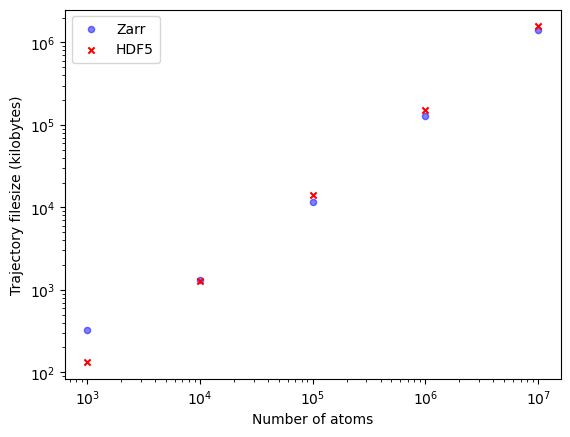

In [20]:
import matplotlib.pyplot as plt

# Graph filesize vs num atoms for hdf5 and zarr

n = np.logspace(3, 7, 5)
print(n)
z_filesize = []
h_filesize =[]

for i in exponential_range(3, 8, 1):
    z_filesize.append(zarr_filesize(f'zarrfiles/zarr_{i}_5.zarr'))
    h_filesize.append(h5_filesize(f'h5files/h5_{i}_5.h5'))

# Graph zarrtraj size vs h5 size
plt.xlabel('Number of atoms')
plt.ylabel('Trajectory filesize (kilobytes)')
plt.xscale('log')
plt.yscale('log')

plt.scatter(n, z_filesize, c='blue', s=20, label="Zarr", alpha=0.5)
plt.scatter(n, h_filesize, c='red', s=20, label="HDF5", marker='x')

plt.legend()

5


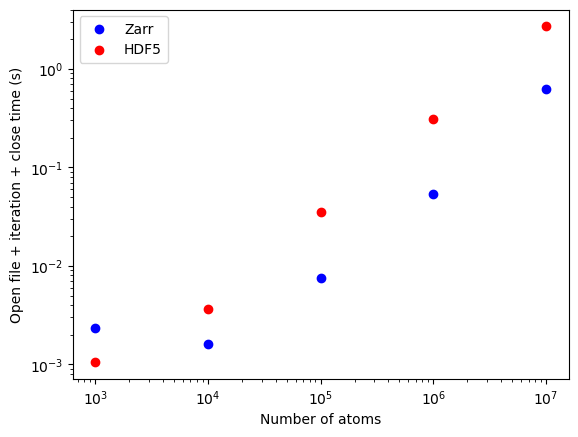

In [22]:
import matplotlib.pyplot as plt

# Graph iteration time vs number atoms for hdf5 and zarr

n = np.logspace(3, 7, 5)
print(len(n))

z_iteration_time = []
h_iteration_time = []

for i in exponential_range(3, 8, 1):
    z_iteration_time.append(zarr_iterate_frames(f'zarrfiles/zarr_{i}_5.zarr'))
    h_iteration_time.append(h5_iterate_frames(f'h5files/h5_{i}_5.h5'))




# Graph zarrtraj time vs h5 size
plt.xlabel('Number of atoms')
plt.ylabel('Open file + iteration + close time (s)')
plt.xscale('log')
plt.yscale('log')
plt.scatter(n, z_iteration_time, c='blue', label="Zarr")
plt.scatter(n, h_iteration_time, c='red', label="HDF5")

plt.legend()


In [24]:
import numpy as np

# pos = np.arange(3 * n_atoms).reshape(n_atoms, 3)

pos = np.arange(3 * 100)
np.random.shuffle(pos)
pos = pos.reshape(100, 3)


print(pos)

[[165 150   0]
 [118 151 117]
 [114 296  35]
 [267 225  94]
 [176 149 257]
 [228  32 244]
 [243 183 236]
 [100 274 194]
 [ 18 237  59]
 [127  57  24]
 [ 43 206 138]
 [ 80 258  21]
 [ 82 247 124]
 [107 173 213]
 [271 134 104]
 [238 115   3]
 [ 92 251 205]
 [147  88 273]
 [ 89 290 179]
 [ 67 113  36]
 [269 246 221]
 [130  45  72]
 [250  19 155]
 [ 11 203  28]
 [252 286 270]
 [215  29 144]
 [122  27 199]
 [ 23 266  76]
 [ 73   4 140]
 [192 152 116]
 [162  15 276]
 [ 81 259 226]
 [ 91 230 212]
 [255   7  61]
 [ 86 167  49]
 [137 223 278]
 [ 63 154  51]
 [ 56 295 172]
 [287  13 170]
 [  5  10 200]
 [239  42 110]
 [ 30 241 291]
 [ 64  74 216]
 [254 128 207]
 [210 222 189]
 [132 293  87]
 [159  26  55]
 [211 204 284]
 [214 245 123]
 [121 197 233]
 [ 34 220  22]
 [ 54 120 164]
 [261 169   6]
 [209  20  77]
 [ 78 260  33]
 [240  95 139]
 [112 282 198]
 [145  90  25]
 [  1 106 157]
 [135 217 277]
 [178 125  46]
 [142 119   2]
 [161 297 285]
 [158 279 131]
 [248 268 133]
 [148  38  60]
 [ 65 208 